## <center>Test Task from
<center> <img src='https://newdermis.ru/wa-data/public/shop/products/14/webp/data/public/site/Logo_kazan.webp' style='width:400px;'>

**by Liliya Kazykhanova**

**Case Description**

Marketplace's client-seller may make a mistake when filling product category field. It can be a reason of low potential profit.

**Task**
* Using the data to build a model that predicts the product category: text, image, other numerical and categorical features.

**Data:** Train and test parquet file + 2 folders with train and test sets of images
- Train dataset contains 6 features, 1 target value - category_id and category_name column is text representation of category_id
- Test dataset - 6 features

**Metrics:** F1-weighted score

**Classification algorithms**: Naive Bayes, LinearSVC, Ensemble (Random Forest)

*Training on CPU*

*Note: Text classification is an example of supervised machine learning since we train the model with labelled data.*

# <p style="text-align:center;font-size:100%;">1. Install and Import</p>

In [1]:
# Installing libs: reading parquet file, morphological analyzer
!pip install pyarrow
!pip install pymystem3

# Loading libs
import pandas as pd # data processing
import numpy as np # linear algebra

# Additional libs
import re # regular expression
from tqdm.auto import tqdm

# Text processing
import nltk #text processing
from pymystem3 import Mystem #morphological analyzer 
from nltk.corpus import stopwords #list of lexical stop words
from string import punctuation #sets of punctuation
nltk.download('stopwords')

# Model
from sklearn import model_selection #split into random train and test subsets/ cross validation
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer #converting text -> token -> normalize data for model
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC #Linear Support Vector Classification model

# metrics
from sklearn import metrics

# Libs for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Fixing RANDOM_SEED to make experiment repetable
RANDOM_SEED = 42

# Fixing package versions to make experiment repetable
!pip freeze > requirements.txt

# <p style="text-align:center;font-size:100%;">2. Data Loading</p>

## Text Preprocessing

In [3]:
# Reading train and test file
DATA_DIR = '/kaggle/input/kazan-express-test/'
df_train = pd.read_parquet(DATA_DIR+'/train.parquet', engine='pyarrow')
df_test = pd.read_parquet(DATA_DIR+'/test.parquet', engine='pyarrow')

print('Train data:\n')
display(df_train.head())

print('\nTest data:\n')
display(df_test.head())

Train data:



,product_id,category_id,sale,shop_id,shop_title,rating,text_fields,category_name
0,325286,12171,False,9031,Aksik,5.0,"{""title"": ""Зарядный кабель Borofone BX1 Lightn...",Все категории->Электроника->Смартфоны и телефо...
1,888134,14233,False,18305,Sela,5.0,"{""title"": ""Трусы Sela"", ""description"": ""Трусы-...",Все категории->Одежда->Женская одежда->Белье и...
3,1267173,13429,False,16357,ЮНЛАНДИЯ канцтовары,5.0,"{""title"": ""Гуашь \""ЮНЫЙ ВОЛШЕБНИК\"", 12 цветов...",Все категории->Хобби и творчество->Рисование->...
4,1416943,2789,False,34666,вася-nicotine,4.0,"{""title"": ""Колба для кальяна Крафт (разные цве...",Все категории->Хобби и творчество->Товары для ...
5,1058275,12834,False,26389,Lim Market,4.6,"{""title"": ""Пижама женская, однотонная с шортам...",Все категории->Одежда->Женская одежда->Домашня...



Test data:



,product_id,sale,shop_id,shop_title,rating,text_fields
1,1997646,False,22758,Sky_Electronics,5.000000,"{""title"": ""Светодиодная лента Smart led Strip ..."
2,927375,False,17729,Di-Di Market,4.405941,"{""title"": ""Стекло ПЛЕНКА керамик матовое Honor..."
3,1921513,False,54327,VisionStore,4.000000,"{""title"": ""Проводные наушники с микрофоном jac..."
4,1668662,False,15000,FORNAILS,5.000000,"{""title"": ""Декоративная табличка \""Правила кух..."
5,1467778,False,39600,МОЯ КУХНЯ,5.000000,"{""title"": ""Подставка под ложку керамическая, п..."


There are 8 columns in train dataset. And 6 columns/features in test dataset.

These two columns - 'category_id' and 'category_name' - describe target value. Numerical and text represenation.

* product_id
* category_id - **target value**
* sale - a flag indicating whether the item is on sale
* shop_id - id number of shop/ seller
* shop_title - name of shop (shop_id and shop_title are related fields, we can drop text representation further)
* rating - average product rating
* text_fields - a dictionary with key:
    - title
    - description (of product)
    - attributes - information in the product card (on website)
    - custom_characteristics, defined_characteristics, filters - netted dictionary with key – attribute field names and values (Цвет: Белый / Черный)
* category_name - name of category by KazanExpress category tree (text represantion of category_id)

The field of Category Name should be deleted before model training because this point could be a reason of **data leak**.

In [4]:
# We have target value only in train_df. Let's check the number of unique classes
print(f'Number of unique classes: {df_train.category_id.nunique()}')

Number of unique classes: 874


In [5]:
"""Joining train and test data into one main dataset for the correct feature processing
- Marking train and test data
- Marking 0 category_id values in test data
"""
df_train['sample'] = 1
df_test['sample'] = 0

df_test['category_id'] = 0

data = df_test.append(df_train, sort=False).reset_index(drop=True)

display(data.head(2))
display(data.tail(2))

,product_id,sale,shop_id,shop_title,rating,text_fields,sample,category_id,category_name
0,1997646,False,22758,Sky_Electronics,5.000000,"{""title"": ""Светодиодная лента Smart led Strip ...",0,0,NaN
1,927375,False,17729,Di-Di Market,4.405941,"{""title"": ""Стекло ПЛЕНКА керамик матовое Honor...",0,0,NaN


,product_id,sale,shop_id,shop_title,rating,text_fields,sample,category_id,category_name
107978,114509,False,2985,Oppa Market,5.0,"{""title"": ""Пульт K10B-C1 для Rolsen"", ""descrip...",1,12100,Все категории->Электроника->Телевизоры и видео...
107979,122515,False,2985,Oppa Market,5.0,"{""title"": ""Пульт DS300A/DC300A/DN300 для цифро...",1,12100,Все категории->Электроника->Телевизоры и видео...


# <p style="text-align:center;font-size:100%;">3. Checking dataset: outliers, duplicates</p>

In [6]:
print(f'Total number of rows: {data.shape[0]}')

# duplicates
all_columns = list(data.columns)
mask_dupl = data.duplicated(subset=all_columns) 
data_duplicates = data[mask_dupl]
print(f'\nNumber of found duplicates: {data_duplicates.shape[0]}')

# features with missing values
nulls_data = data.isnull().sum()
nulls = nulls_data[nulls_data > 0]
print(f'\nFeatures with nulls: {nulls_data[nulls_data>0].count()}\n{nulls}')

Total number of rows: 107980

Number of found duplicates: 0

Features with nulls: 1
category_name    16860
dtype: int64


After joining train and test dataset we got 1 column with NaN values - **category_name**.
This row is text value of category tree (or category_id which is target).

In [7]:
print('Total information about type of features:\n')
display(data.info())

Total information about type of features:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107980 entries, 0 to 107979
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   product_id     107980 non-null  int64  
 1   sale           107980 non-null  bool   
 2   shop_id        107980 non-null  int64  
 3   shop_title     107980 non-null  object 
 4   rating         107980 non-null  float64
 5   text_fields    107980 non-null  object 
 6   sample         107980 non-null  int64  
 7   category_id    107980 non-null  int64  
 8   category_name  91120 non-null   object 
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 6.7+ MB


None

We have 6 features and 1 target variable 'category_id' (additional column - category_name):
* **CATEGORICAL**:
    * 'product_id'
    * 'sale'
    * 'shop_id' ('shop_title')
    
* **CONTINIOUS**:
    * 'rating'
   

We should extract from 'text_field' column in order to check what type of information we have.

In [8]:
# Statistic information of Numerical data
print('Descriptive statistics of data:')
data['rating'].describe()

Descriptive statistics of data:


count    107980.000000
mean          4.600022
std           0.821469
min           1.000000
25%           4.575758
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

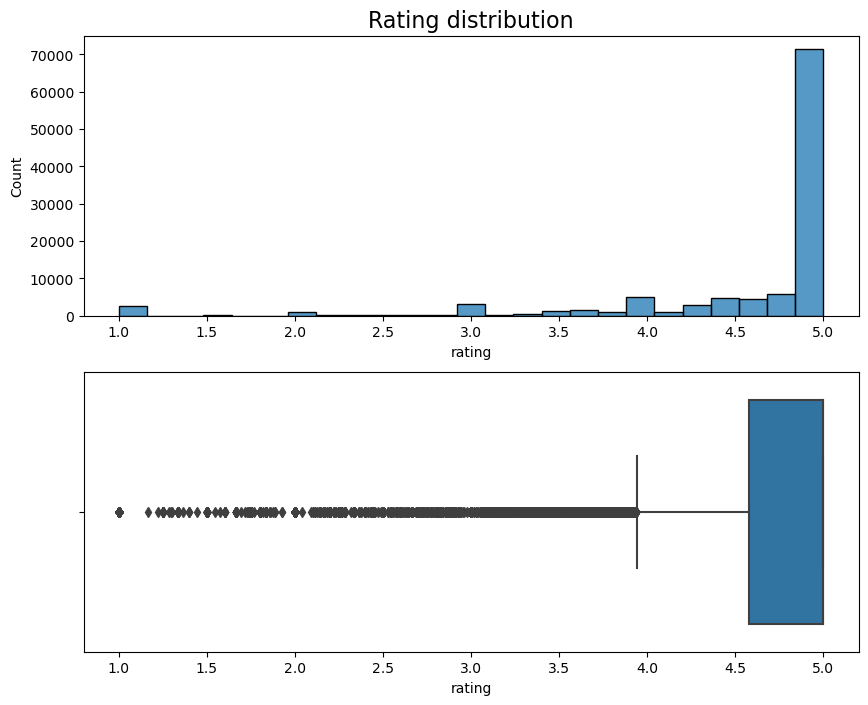

In [9]:
# Let's look at the rating distribution
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

histplot_rating = sns.histplot(
    data=data,
    x='rating',
    bins=25,
    ax=axes[0])
histplot_rating.set_title('Rating distribution', fontsize=16);

boxplot_rating = sns.boxplot(
    data=data,
    x='rating',
    ax=axes[1]);

Rating values have abnormal distribution because histogram curve is not look as a bell.

In [10]:
# More than 60% is 5 mark, the other marks less than 1% (each of them, separately)
display(data.rating.value_counts(normalize=True))
rating_marks = list(data['rating'].unique())

print('\nRating marks: min value - ', sorted(rating_marks)[0])
print('\nRating marks: max value - ', sorted(rating_marks)[-1])
print('\nRating marks (example):', sorted(rating_marks)[:10])

5.000000    0.616364
4.000000    0.044379
3.000000    0.029255
4.500000    0.026912
1.000000    0.023347
              ...   
4.704918    0.000009
4.296875    0.000009
3.352113    0.000009
3.962963    0.000009
3.620690    0.000009
Name: rating, Length: 2598, dtype: float64


Rating marks: min value -  1.0

Rating marks: max value -  5.0

Rating marks (example): [1.0, 1.1666666666666667, 1.2222222222222223, 1.25, 1.2857142857142858, 1.2941176470588236, 1.3, 1.3333333333333333, 1.3636363636363635, 1.4]


In [11]:
# Statistic information of Object data
print('Descriptive statistics of object data:')
data.describe(include=['object'])

Descriptive statistics of object data:


,shop_title,text_fields,category_name
count,107980,107980,91120
unique,11126,107378,874
top,Чехлович,"{""title"": ""Ткань сатин"", ""description"": ""<p>Са...",Все категории->Электроника->Смартфоны и телефо...
freq,1401,23,6590


In [12]:
"""
Define Unique categories in each column
"""
unique_list = []
for col in data.columns:
    # creating tuple: column name, number of unique values, type
    item = (col, data[col].nunique(), data[col].dtypes, data[col].unique())
    unique_list.append(item)
    
unique_counts = pd.DataFrame(
    unique_list,
    columns=['Column_Name', 'Num_Unique', 'Type', 'Unique_category']
).sort_values(by='Num_Unique', ignore_index=True)


display(unique_counts)

,Column_Name,Num_Unique,Type,Unique_category
0,sale,2,bool,"[False, True]"
1,sample,2,int64,"[0, 1]"
2,category_name,874,object,"[nan, Все категории->Электроника->Смартфоны и ..."
3,category_id,875,int64,"[0, 12171, 14233, 13429, 2789, 12834, 13337, 1..."
4,rating,2598,float64,"[5.0, 4.405940594059406, 4.0, 3.66666666666666..."
5,shop_id,11126,int64,"[22758, 17729, 54327, 15000, 39600, 23905, 123..."
6,shop_title,11126,object,"[Sky_Electronics, Di-Di Market, VisionStore, F..."
7,text_fields,107378,object,"[{""title"": ""Светодиодная лента Smart led Strip..."
8,product_id,107980,int64,"[1997646, 927375, 1921513, 1668662, 1467778, 1..."


# <p style="text-align:center;font-size:100%;">4. Feature Engineering</p>

In [13]:
# Let's make a copy of the given DataFrame in order to protect original DF
df = data.copy()

## **`Rating`**

I'm not sure that this feature is meaningful in product category prediction. And moreover more than 60% of samples have 5 marks.

I just transform rating values to int and round it.

In [14]:
# Transform rating to int -> round
df['rating'] = df['rating'].astype(np.float32).round()

In [15]:
df.rating.value_counts(normalize=True)

5.0    0.758603
4.0    0.157946
3.0    0.042730
1.0    0.023801
2.0    0.016920
Name: rating, dtype: float64

Now we have 76% of 5 mark, 16% of 4 mark and other marks less than 10%.

## **`Sale`**

In [16]:
# Converting bool type to numeric
df['sale'] = df['sale'].apply(lambda x: 1 if x == True else 0)

In [17]:
df.sale.value_counts(normalize=True)

0    0.986766
1    0.013234
Name: sale, dtype: float64

As you can see only 1% of our product has sale flag. And this feature is also has not any sense in product classification process.

## **`Category Name`**

So, our goal is to predict product category and our target value is category_id.
But it is only numbers.

I want to look at the text description of category tree. This information is presented in category_name column.

In [18]:
"""
Getting list of category (elements of category tree)
"""
df_temp = df.query('sample == 1').drop(['sample'], axis=1) #copying working df

# split the string by the occurrences of the regex pattern, returning a list containing the resulting substrings
df_temp['category_name'] = df_temp['category_name'].apply(lambda x: re.split('->', x))
df_temp.head()

,product_id,sale,shop_id,shop_title,rating,text_fields,category_id,category_name
16860,325286,0,9031,Aksik,5.0,"{""title"": ""Зарядный кабель Borofone BX1 Lightn...",12171,"[Все категории, Электроника, Смартфоны и телеф..."
16861,888134,0,18305,Sela,5.0,"{""title"": ""Трусы Sela"", ""description"": ""Трусы-...",14233,"[Все категории, Одежда, Женская одежда, Белье ..."
16862,1267173,0,16357,ЮНЛАНДИЯ канцтовары,5.0,"{""title"": ""Гуашь \""ЮНЫЙ ВОЛШЕБНИК\"", 12 цветов...",13429,"[Все категории, Хобби и творчество, Рисование,..."
16863,1416943,0,34666,вася-nicotine,4.0,"{""title"": ""Колба для кальяна Крафт (разные цве...",2789,"[Все категории, Хобби и творчество, Товары для..."
16864,1058275,0,26389,Lim Market,5.0,"{""title"": ""Пижама женская, однотонная с шортам...",12834,"[Все категории, Одежда, Женская одежда, Домашн..."


In [19]:
cat = pd.DataFrame(df_temp['category_name'].to_list()) # listing the categories separately

cat.head()

,0,1,2,3,4,5
0,Все категории,Электроника,Смартфоны и телефоны,Аксессуары и запчасти,Зарядные устройства и кабели,Кабели
1,Все категории,Одежда,Женская одежда,Белье и купальники,Трусы,None
2,Все категории,Хобби и творчество,Рисование,"Краски, пигменты",None,None
3,Все категории,Хобби и творчество,Товары для курения,Кальяны и аксессуары,Колбы,None
4,Все категории,Одежда,Женская одежда,Домашняя одежда,Пижамы,None


Category tree has 6 levels.

As you can see category tree lenght for some of product is only 4-5 levels.

In [20]:
cat.shape

(91120, 6)

In [21]:
# Let's look how many unique product categories(names) are consisted in every levels
print(f'Category tree - "all categories" - number of values: {cat[0].nunique()}')
print(f'\nCategory tree - "first level category" - number of values: {cat[1].nunique()}')
print(f'\nCategory tree - "first level subcategory" - number of values: {cat[2].nunique()}')
print(f'\nCategory tree - "second level subcategory" - number of values: {cat[3].nunique()}')
print(f'\nCategory tree - "third level subcategory" - number of values: {cat[4].nunique()}')
print(f'\nCategory tree - "fourth level subcategory" - number of values: {cat[5].nunique()}')

Category tree - "all categories" - number of values: 1

Category tree - "first level category" - number of values: 5

Category tree - "first level subcategory" - number of values: 45

Category tree - "second level subcategory" - number of values: 278

Category tree - "third level subcategory" - number of values: 532

Category tree - "fourth level subcategory" - number of values: 111


In [22]:
print(f'First level categories: {cat[1].unique()}')

First level categories: ['Электроника' 'Одежда' 'Хобби и творчество' 'Товары для дома' 'Обувь']


In [23]:
# Getting df with frequency of products in First level categories
first_level_cat = cat[1].value_counts().reset_index()
first_level_cat.columns = ['Category Name', 'Cnt of Products']
first_level_cat

,Category Name,Cnt of Products
0,Товары для дома,31912
1,Электроника,26224
2,Одежда,17010
3,Хобби и творчество,14346
4,Обувь,1628


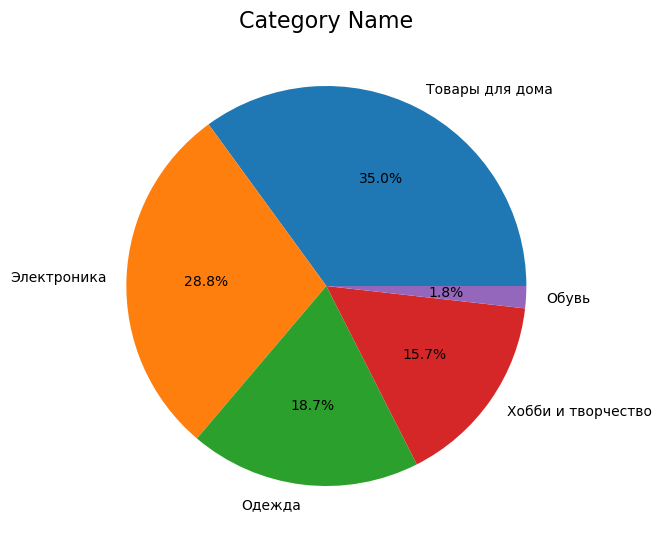

In [24]:
# Let's build a pie chart to look at the distribution of high level categories (5 groups)
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])

axes.pie(
    first_level_cat['Cnt of Products'],
    labels=first_level_cat['Category Name'],
    autopct='%.1f%%'
);

axes.set_title('Category Name', fontsize=16);

The smallest category is 'Обувь' ~ 2%. Maybe our model will has a problem to predict subcategory of this category.

In [25]:
"""
Getting df with frequency of products in First level subcategories
"""
cat_home = cat[cat[1] == 'Товары для дома'][2].value_counts().reset_index()
cat_home.columns = ['Subcategory Name', 'Cnt of Products']

# Adding Category Name at the first place
cat_home.insert(0,'Category Name', 'Товары для дома')


cat_elect = cat[cat[1] == 'Электроника'][2].value_counts().reset_index()
cat_elect.columns = ['Subcategory Name', 'Cnt of Products']
cat_elect.insert(0,'Category Name', 'Электроника')


cat_clothes = cat[cat[1] == 'Одежда'][2].value_counts().reset_index()
cat_clothes.columns = ['Subcategory Name', 'Cnt of Products']
cat_clothes.insert(0,'Category Name', 'Одежда')


cat_hobby = cat[cat[1] == 'Хобби и творчество'][2].value_counts().reset_index()
cat_hobby.columns = ['Subcategory Name', 'Cnt of Products']
cat_hobby.insert(0,'Category Name', 'Хобби и творчество')


cat_shoes = cat[cat[1] == 'Обувь'][2].value_counts().reset_index()
cat_shoes.columns = ['Subcategory Name', 'Cnt of Products']
cat_shoes.insert(0,'Category Name', 'Обувь')

In [26]:
frames = [cat_home, cat_elect, cat_clothes, cat_hobby, cat_shoes]

category_level = pd.concat(frames)
category_level

,Category Name,Subcategory Name,Cnt of Products
0,Товары для дома,Товары для кухни,11243
1,Товары для дома,Товары для праздников,9655
2,Товары для дома,Хозяйственные товары,3452
3,Товары для дома,Декор и интерьер,3416
4,Товары для дома,Текстиль,2061
5,Товары для дома,Хранение вещей,1039
6,Товары для дома,Товары для бани и сауны,503
7,Товары для дома,Товары для комнатных растений,317
8,Товары для дома,Мебель,226
0,Электроника,Смартфоны и телефоны,14685


As you can see, some of the subcategories have less than 10 examples ('Электроника').

It means that ML model could has a problem with prediction of these classes correctly.

***

In [27]:
"""
Let's come back to our working df and extracting category tree level into different columns

Function to get elements from each category tree level and creating new column with extracting information
"""
def get_level_0(category_level):
    cat_0 = category_level[0]
    
    return cat_0


def get_level_1(category_level):
    cat_1 = category_level[1]
    
    return cat_1


def get_level_2(category_level):
    cat_2 = category_level[2]
    
    return cat_2


def get_level_3(category_level):
    if len(category_level) >= 4:
        cat_3 = category_level[3]
    else:
        cat_3 = None
    
    return cat_3


def get_level_4(category_level):
    if len(category_level) > 4:
        cat_4 = category_level[4]
    else:
        cat_4 = None
    
    return cat_4


def get_level_5(category_level):
    if len(category_level) > 5:
        cat_5 = category_level[5]
    else:
        cat_5 = None
    
    return cat_5


df_temp['category_0'] = df_temp['category_name'].apply(get_level_0)
df_temp['category_1'] = df_temp['category_name'].apply(get_level_1)
df_temp['category_2'] = df_temp['category_name'].apply(get_level_2)
df_temp['category_3'] = df_temp['category_name'].apply(get_level_3)
df_temp['category_4'] = df_temp['category_name'].apply(get_level_4)
df_temp['category_5'] = df_temp['category_name'].apply(get_level_5)

In [28]:
# Getting table with frequency by category_id (category_1 and category_2)
df_temp.groupby(['category_1', 'category_2'])['product_id'].count()

category_1          category_2                            
Обувь               Аксессуары для обуви                        359
                    Женская обувь                               736
                    Мужская обувь                               374
                    Обувь для девочек                            92
                    Обувь для мальчиков                          67
Одежда              Детская одежда                             4536
                    Женская одежда                             9396
                    Мужская одежда                             2926
                    Спецодежда                                  152
Товары для дома     Декор и интерьер                           3416
                    Мебель                                      226
                    Текстиль                                   2061
                    Товары для бани и сауны                     503
                    Товары для комнатных растений        

In [29]:
# Getting table with frequency by category_id (category_3)
df_temp.groupby(['category_2', 'category_id'])['product_id'].count()

category_2                     category_id
Аксессуары для обуви           14611           92
                               14612           23
                               14613            6
                               14614          190
                               14615           35
                                             ... 
Хранение вещей                 13954          359
                               15024          143
                               15025           94
                               15026           36
Часы и электронные будильники  12273           70
Name: product_id, Length: 874, dtype: int64

In [30]:
# Let's check the distribution of the number of examples in classes (category_id)
df_temp['category_id'].value_counts()

11937    6590
14922    3709
13651    1463
13143    1460
12980    1222
         ... 
12808       2
12901       1
11549       1
11875       1
12836       1
Name: category_id, Length: 874, dtype: int64

In [31]:
# Let's look at the classes with only 1-2 example(s)
display(df_temp[df_temp['category_id'] == 12836])
display(df_temp[df_temp['category_id'] == 11549])
display(df_temp[df_temp['category_id'] == 12808])

,product_id,sale,shop_id,shop_title,rating,text_fields,category_id,category_name,category_0,category_1,category_2,category_3,category_4,category_5
27909,305997,0,2939,GUWAPO,5.0,"{""title"": ""Пиджак мужской"", ""description"": ""<p...",12836,"[Все категории, Одежда, Мужская одежда, Пиджак...",Все категории,Одежда,Мужская одежда,Пиджаки и жилеты,Пиджаки,None


,product_id,sale,shop_id,shop_title,rating,text_fields,category_id,category_name,category_0,category_1,category_2,category_3,category_4,category_5
59770,831567,0,19574,SOFIA MUM,4.0,"{""title"": ""Толстовка утепленная для беременных...",11549,"[Все категории, Одежда, Женская одежда, Одежда...",Все категории,Одежда,Женская одежда,Одежда для беременных,Толстовки и олимпийки,None


,product_id,sale,shop_id,shop_title,rating,text_fields,category_id,category_name,category_0,category_1,category_2,category_3,category_4,category_5
66385,1542041,0,42702,Эмальто,5.0,"{""title"": ""Сабо детские, 3 цвета, размеры 24-3...",12808,"[Все категории, Обувь, Обувь для мальчиков, Са...",Все категории,Обувь,Обувь для мальчиков,Сандалии,Сабо,None
105693,1133637,0,4449,TOPS,5.0,"{""title"": ""Сабо детские TOPS"", ""description"": ...",12808,"[Все категории, Обувь, Обувь для мальчиков, Са...",Все категории,Обувь,Обувь для мальчиков,Сандалии,Сабо,None


In [32]:
df_temp[df_temp['category_3'] == 'Пиджаки и жилеты']

,product_id,sale,shop_id,shop_title,rating,text_fields,category_id,category_name,category_0,category_1,category_2,category_3,category_4,category_5
27909,305997,0,2939,GUWAPO,5.0,"{""title"": ""Пиджак мужской"", ""description"": ""<p...",12836,"[Все категории, Одежда, Мужская одежда, Пиджак...",Все категории,Одежда,Мужская одежда,Пиджаки и жилеты,Пиджаки,None


As you can see, there is not any mistake in words of category_name (it could be a reason of low number of examples).

We have categories (/classes) with only 1 example. And this is really a problem for model to predict these classes.
Before model training we split data into train/ test (or train/val/test). And it's impossible to split only one example into 2/3 sets. And we get unbalanced samples.
So, let's check how many categories have less than 20 examples.

In [33]:
# Getting new columns - number of examples in each classes
df['category_id_cnt'] = df[df['sample'] == 1].groupby('category_id')['category_id'].transform('count')
df.tail()

,product_id,sale,shop_id,shop_title,rating,text_fields,sample,category_id,category_name,category_id_cnt
107975,114402,0,4955,СТЕКЛОФФ ПРО,4.0,"{""title"": ""Прочное стекло 2D на Samsung Galaxy...",1,14922,Все категории->Электроника->Смартфоны и телефо...,3709.0
107976,1594500,0,19626,Hobby room,5.0,"{""title"": ""Алмазная мозаика \""Ромашки\"" 40*50с...",1,13028,"Все категории->Хобби и творчество->Пазлы, моза...",475.0
107977,790493,0,22291,Море открыток,5.0,"{""title"": ""Открытка \""Вместе навсегда\"" в краф...",1,13407,Все категории->Товары для дома->Товары для пра...,1152.0
107978,114509,0,2985,Oppa Market,5.0,"{""title"": ""Пульт K10B-C1 для Rolsen"", ""descrip...",1,12100,Все категории->Электроника->Телевизоры и видео...,547.0
107979,122515,0,2985,Oppa Market,5.0,"{""title"": ""Пульт DS300A/DC300A/DN300 для цифро...",1,12100,Все категории->Электроника->Телевизоры и видео...,547.0


In [34]:
print('Number of categories with 20 or less examples:\n')
display(df[df['category_id_cnt'] <= 20]['product_id'].count())

print('\nProduct category with 20 or less examples:\n')
display(df[df['category_id_cnt'] <= 20]['category_name'])

Number of categories with 20 or less examples:



3192


Product category with 20 or less examples:



16863     Все категории->Хобби и творчество->Товары для ...
16987     Все категории->Обувь->Обувь для девочек->Босон...
17019     Все категории->Электроника->Смартфоны и телефо...
17070     Все категории->Одежда->Детская одежда->Одежда ...
17112        Все категории->Товары для дома->Мебель->Кресла
                                ...                        
107763    Все категории->Электроника->Фото- и видеотехни...
107769    Все категории->Товары для дома->Текстиль->Штор...
107854    Все категории->Товары для дома->Товары для кух...
107914    Все категории->Товары для дома->Товары для пра...
107952    Все категории->Товары для дома->Товары для пра...
Name: category_name, Length: 3192, dtype: object

About 3% categories have 20 or less examples. I guess that we can drop these data before training model, because it's not a big part of dataset.

## **`Text Fields`**

Text fields - our main source to getting meaningful data for product category prediction.

Let's look what kind of information we can extract.

In [35]:
# Getting dict from str format
df['text_fields'] = df['text_fields'].apply(lambda x: eval(x))

In [36]:
# Look at the list of dict keys
df['text_fields'][0].keys()

dict_keys(['title', 'description', 'attributes', 'custom_characteristics', 'defined_characteristics', 'filters'])

In [37]:
# Creating new columns
df['title'] = df.text_fields.apply(lambda x: x['title'])
df['description'] = df.text_fields.apply(lambda x: x['description'])
df['attributes'] = df.text_fields.apply(lambda x: x['attributes'])
df['custom_characteristics'] = df.text_fields.apply(lambda x: x['custom_characteristics'])
df['defined_characteristics'] = df.text_fields.apply(lambda x: x['defined_characteristics'])
df['filters'] = df.text_fields.apply(lambda x: x['filters'])

In [38]:
df.head()

,product_id,sale,shop_id,shop_title,rating,text_fields,sample,category_id,category_name,category_id_cnt,title,description,attributes,custom_characteristics,defined_characteristics,filters
0,1997646,0,22758,Sky_Electronics,5.0,{'title': 'Светодиодная лента Smart led Strip ...,0,0,NaN,NaN,"Светодиодная лента Smart led Strip Light, с пу...","<p>Светодиодная лента LED, 5 м, RGB (Цветная) ...","[Легкость управления с пульта, а так же смартф...",{},{},"{'Тип питания': ['От сети', 'От USB'], 'В комп..."
1,927375,0,17729,Di-Di Market,4.0,{'title': 'Стекло ПЛЕНКА керамик матовое Honor...,0,0,NaN,NaN,Стекло ПЛЕНКА керамик матовое Honor 50 lite 10...,"<p><span style=""color: rgb(63, 62, 62);"">Защит...",[Honor 50 ПЛЕНКА!!! КРАЯ КЛЕЮТСЯ МОГУТ НЕ ПРО...,"{'Модель': ['8a - Y6 2019', '9x - P Smart Z', ...",{},"{'Модель устройства': ['Honor 9X', 'Honor 20 P..."
2,1921513,0,54327,VisionStore,4.0,{'title': 'Проводные наушники с микрофоном jac...,0,0,NaN,NaN,"Проводные наушники с микрофоном jack 3.5, IOS,...",<p>Наушники проводные с микрофоном отличное ка...,[Возможность использования как гарнитуры для П...,{},{},"{'Разъем': ['3.5 мм'], 'Конструкция наушников'..."
3,1668662,0,15000,FORNAILS,5.0,"{'title': 'Декоративная табличка ""Правила кухн...",0,0,NaN,NaN,"Декоративная табличка ""Правила кухни"", подстав...","<p>Декоративная табличка ""Правила кухни"" созда...",[],{},{},{'Бренд': ['FORNAILS']}
4,1467778,0,39600,МОЯ КУХНЯ,5.0,"{'title': 'Подставка под ложку керамическая, п...",0,0,NaN,NaN,"Подставка под ложку керамическая, подложка ""Кл...",<p>Подложка керамическая с рисунком в подарочн...,"[Керамика., Размер: 255*90*30мм; ]","{'Модель': ['Клубника', 'Лимоны', 'Лаванда']}",{},"{'Бренд': ['Valleya', 'Valleya', 'Valleya']}"


After extraction text_fields features I got 6 new columns:
- title
- description
- attributes
- custom_characteristics
- defined_characteristics
- filters

Let's look what type of information is really useful:
- title - product name (!)
- description consists of information about product name, usage way, characteristics, shop_name - it sounds like duplicate the information from the other columns
- attributes - ingredients and product characteristics(!)
- custom_characteristics: Age (возраст), Model (модель), Size (размер/ рост), Volume(объем), Quantity(количество), Pic(рисунок), et.s
- defined_characteristics
- filters (color. size, et.s.)

In [39]:
"""
Let's look at the custom_characteristics, defined_characteristics and filters columns
"""
df['custom_characteristics'] = df['custom_characteristics'].apply(lambda x: np.nan if x == {} else x)
df['defined_characteristics'] = df['defined_characteristics'].apply(lambda x: np.nan if x == {} else x)
df['filters'] = df['filters'].apply(lambda x: np.nan if x == {} else x)

In [40]:
print(f'Number of nan values in "custom_characteristics" column: {df.custom_characteristics.isnull().sum()}')
print(f'\nNumber of nan values in "defined_characteristics" column: {df.defined_characteristics.isnull().sum()}')
print(f'\nNumber of nan values in "filters" column: {df.filters.isnull().sum()}')

Number of nan values in "custom_characteristics" column: 85307

Number of nan values in "defined_characteristics" column: 65302

Number of nan values in "filters" column: 51486


* Almost 80% data of custom_characteristics column is nan value (null)
* Almost 60% data of defined_characteristics column is nan value (null)
* Almost 50% data of filters column is nan value (null)

Maybe at this step we pass these columns because they consist a lot of missing values (more than 30%).

In another situation we could use the following options to fill in missing values:
- fill in with constant values (mode - for categorical varialbes | mean/ median/ mode for numerical)
- fill in with constant values + indicator of MV (additional column)
- fill in based on group characteristics

In [41]:
# Let's look at the title field
df.title.iloc[1000:1020]

1000     Набор бумажной посуды "Крутые тачки" на 6 персон
1001    Стикерпак аниме "Hunter x hunter" №2, 50шт сти...
1002    Ершик для унитаза силиконовый на подставке. Белый
1003                        Набор фигурок из 2 школьников
1004    Защитное стекло 9D на Xiaomi Mi 10T / Xiaomi M...
1005            Силиконовая 3D наклейка-стикер на телефон
1006    Чехол для Huawei Honor 10i, Honor 20i черный м...
1007                              Фломограф электрический
1008    Выведен Стикерпак мультфильм "Том и Джерри", 5...
1009      Полоса для сварки аккумуляторов 0.15*6мм 1 метр
1010                      Нарды, шашки "Леопарды", дерево
1011    Корзина для мусора на дверцу шкафа, органайзер...
1012       Ерш для шахты деревянная ручка 65 см (Широкий)
1013            Держатель-присоска универсальный "Ладонь"
1014    Форма силиконовая для льда и шоколада "Пистолеты"
1015    Копилка металл для монет и купюр/ Банка для хр...
1016    Защитное стекло Vivo Y95 / Y91 / Y91c / Y93 LI...
1017        Бе

In 'title' column there is text description of product. We need to preprocess this type of data before using it for model.

Necessary steps:
- Tokenization — convert sentences to words
- Removing unnecessary punctuation, tags
- Removing stop words (frequent words which have not any semantic sense)
- Lemmatization — reducing words to their root word
- Vectorization - numerically representation of text (tf-idf encoding)

In [42]:
# Data type change
df['title'] = df['title'].astype(str)

# Counting number of words
print(df['title'].apply(lambda x: len(x.split(' '))).sum())

783485


There are 783 485 words in the data

In [43]:
"""
In this step I did text normalization:
* removing meaningless words
* removing punctuation
* removing latin letters, numerical values
* stopwords removal
* converting to lower case
* tokenize - convert from strings to lists of words
* lemmatization - convert the word into a root word

Using pymystem3 in order to get correct word form based on the context
Трусы -> трусы - correct
Трусы -> трус - false
"""
m = Mystem()
patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"

# Use stopwords_ru list from nltk
stopwords_ru = stopwords.words('russian')
stopwords_ru.extend(['на','с','и', 'по', 'к', '", ', 'х',
                     'см', 'мм', 'м', 'л', 'шт', 'мл']) # x - russian letter


def lemmatize_sentence(text):
    text = re.sub(patterns, ' ', text)
    tokens = []
    
    for token in text.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = m.lemmatize(token)[0]
            
            tokens.append(token)
            
    return ' '.join(tokens) # back to string from list

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [44]:
print('Before lemmatization:', df['title'].iloc[2001])
print('After lemmatization:', lemmatize_sentence(df['title'].iloc[2001]))

Before lemmatization: Клавиатура для ноутбука Acer Aspire 5810T
After lemmatization: клавиатура ноутбук


In [45]:
df['title_lem'] = df['title'].apply(lemmatize_sentence)

In [46]:
df.head(3)

,product_id,sale,shop_id,shop_title,rating,text_fields,sample,category_id,category_name,category_id_cnt,title,description,attributes,custom_characteristics,defined_characteristics,filters,title_lem
0,1997646,0,22758,Sky_Electronics,5.0,{'title': 'Светодиодная лента Smart led Strip ...,0,0,NaN,NaN,"Светодиодная лента Smart led Strip Light, с пу...","<p>Светодиодная лента LED, 5 м, RGB (Цветная) ...","[Легкость управления с пульта, а так же смартф...",NaN,NaN,"{'Тип питания': ['От сети', 'От USB'], 'В комп...",светодиодный лента пульт метр
1,927375,0,17729,Di-Di Market,4.0,{'title': 'Стекло ПЛЕНКА керамик матовое Honor...,0,0,NaN,NaN,Стекло ПЛЕНКА керамик матовое Honor 50 lite 10...,"<p><span style=""color: rgb(63, 62, 62);"">Защит...",[Honor 50 ПЛЕНКА!!! КРАЯ КЛЕЮТСЯ МОГУТ НЕ ПРО...,"{'Модель': ['8a - Y6 2019', '9x - P Smart Z', ...",NaN,"{'Модель устройства': ['Honor 9X', 'Honor 20 P...",стекло пленка керамика матовый
2,1921513,0,54327,VisionStore,4.0,{'title': 'Проводные наушники с микрофоном jac...,0,0,NaN,NaN,"Проводные наушники с микрофоном jack 3.5, IOS,...",<p>Наушники проводные с микрофоном отличное ка...,[Возможность использования как гарнитуры для П...,NaN,NaN,"{'Разъем': ['3.5 мм'], 'Конструкция наушников'...",проводной наушник микрофон


***

## Image preprocessing

In [47]:
# """ Basic ideas about image preprocessing
# From the condition of this project I know that image data has the same name as values in prodict_id column.
# Let's load image data
# """
# # Importing additional libs
# !pip install keras --user
# !pip install Keras-Preprocessing
# !pip install -qqq ipyplot

# import glob
# import keras
# import cv2 #read image
# from keras_preprocessing.image import ImageDataGenerator #for data agumentation
# from ipyplot import plot_images #plot images


# # Creating new df for train image data
# df_train_imgs = df_train.loc[:, ['product_id', 'category_id']]

# # Path to train_images
# path = DATA_DIR+'/images/train/'

# """
# Function to add .jpg value to product_id row
# """
# def to_jpg(id):
#     return id+'.jpg'


# # Images in 'train' folder
# # Getting new df with path to train image data
# df_train_imgs['product_id'] = df_train_imgs['product_id'].astype(str)
# df_train_imgs['product_id'] = df_train_imgs['product_id'].apply(to_jpg)

# df_train_imgs['product_id'] = df_train_imgs['product_id'].apply(lambda x: path + x)
# print('Train images dataframe: \n')
# display(df_train_imgs.head())
# # Result: <Train images dataframe:>


# # Images in 'test' folder
# test_imgs = []
# for file in glob.glob(DATA_DIR+'/images/test/*.jpg'):
#     test_imgs.append({'product_id': file})
    
# df_test_imgs = pd.DataFrame(test_imgs)
# print(f'Test images number: {len(df_test_imgs)}')
# print('\nTest images dataframe: \n')
# display(df_test_imgs.head())
# # Result: Test images number: 16860
# #        <Test images dataframe: >


# # Show several images from train
# images = df_train_imgs.product_id.sample(10).tolist()
# plot_images(images, max_images=10,img_width=220,force_b64=True)


# # Let's look at the shape of image
# img = cv2.imread(DATA_DIR+'/images/test/1997646.jpg')
# print(img.shape)
# # Result: (512, 512, 3)


# '''Increasing number of train image with ImageDataGenerator(), Keras libs

# Creating new configuration of images:
# * horizontal/ vertical flip, zooming, rotation, et.s.

# At the traning step each epoch gets 'new' set of images.
# Dividing train dataset into train and valid, 80/20
# '''
# # Transforming category_id data type -> str
# df_train_imgs['category_id'] = df_train_imgs['category_id'].astype(str)

# gen = ImageDataGenerator(
#     rescale=1./255.,
#     horizontal_flip = True,
#     validation_split=0.2
# )
 
# train_generator = gen.flow_from_dataframe(
#     df_train_imgs,
#     directory = DATA_DIR+'/images/train',
#     x_col = 'product_id',
#     y_col = 'category_id',
#     subset='training',
#     color_mode='rgb',
#     target_size = (512,512), # image height , image width
#     class_mode='categorical',
#     batch_size=32,
#     seed=RANDOM_SEED,
# )
 
# validation_generator = gen.flow_from_dataframe(
#     df_train_imgs, # dataframe
#     directory = DATA_DIR+'/images/train',
#     x_col = 'product_id',
#     y_col = 'category_id',
#     subset='validation',
#     color_mode='rgb',
#     target_size = (512,512), # image height , image width
#     class_mode='categorical',
#     batch_size=32,
#     seed=RANDOM_SEED,
# )
# # Result: Found 72896 validated image filenames belonging to 874 classes
# #         Found 18224 validated image filenames belonging to 874 classes


# # Let’s see what a single batch of data looks like
# x,y = next(train_generator)
# x.shape # input shape of one record is (512,512,3) , 32: is the batch size
# # Result: (32, 512, 512, 3)


# # Plotting images from the train dataset
# a = train_generator.class_indices
# class_names = list(a.keys())  # storing class names in a list 

# def plot_images(img, labels):
#     plt.figure(figsize=[15, 10])
#     for i in range(10):
#         plt.subplot(5, 5, i+1)
#         plt.imshow(img[i])
#         plt.title(class_names[np.argmax(labels[i])])
#         plt.axis('off')
        
        
# plot_images(x,y)

# """
# After we can start to build model (if NN)
# - adding embedding (convert image -> vector)
# - NN layers (last layer output shape should be (, 874) - in according to class number)
# """

# <p style="text-align:center;font-size:100%;">5. Model</p>

In [48]:
# dividing dataset into train and test
train_df = df.query('sample == 1').drop(['sample'], axis=1)
test_df = df.query('sample == 0').drop(columns = ['sample', 'category_name'], axis=1)

In [49]:
print(f'Train dataset: {train_df.shape}\n')
display(train_df.head(2))

print(f'\nTest dataset: {test_df.shape}\n')
display(test_df.head(2))

Train dataset: (91120, 16)



,product_id,sale,shop_id,shop_title,rating,text_fields,category_id,category_name,category_id_cnt,title,description,attributes,custom_characteristics,defined_characteristics,filters,title_lem
16860,325286,0,9031,Aksik,5.0,{'title': 'Зарядный кабель Borofone BX1 Lightn...,12171,Все категории->Электроника->Смартфоны и телефо...,1058.0,Зарядный кабель Borofone BX1 Lightning для айф...,"<p><span style=""background-color: transparent;...","[Длина: 1м, Разъем: Lightning, Подерживает быс...",NaN,"{'Цвет': ['Черный', 'Белый']}","{'Цвет': ['Белый', 'Черный']}",зарядный кабель айфон
16861,888134,0,18305,Sela,5.0,"{'title': 'Трусы Sela', 'description': 'Трусы-...",14233,Все категории->Одежда->Женская одежда->Белье и...,947.0,Трусы Sela,Трусы-слипы из эластичного бесшовного трикотаж...,[],NaN,{'Размер одежды': ['S']},"{'Бренд': ['Sela'], 'Размер одежды': ['S']}",трусы



Test dataset: (16860, 15)



,product_id,sale,shop_id,shop_title,rating,text_fields,category_id,category_id_cnt,title,description,attributes,custom_characteristics,defined_characteristics,filters,title_lem
0,1997646,0,22758,Sky_Electronics,5.0,{'title': 'Светодиодная лента Smart led Strip ...,0,NaN,"Светодиодная лента Smart led Strip Light, с пу...","<p>Светодиодная лента LED, 5 м, RGB (Цветная) ...","[Легкость управления с пульта, а так же смартф...",NaN,NaN,"{'Тип питания': ['От сети', 'От USB'], 'В комп...",светодиодный лента пульт метр
1,927375,0,17729,Di-Di Market,4.0,{'title': 'Стекло ПЛЕНКА керамик матовое Honor...,0,NaN,Стекло ПЛЕНКА керамик матовое Honor 50 lite 10...,"<p><span style=""color: rgb(63, 62, 62);"">Защит...",[Honor 50 ПЛЕНКА!!! КРАЯ КЛЕЮТСЯ МОГУТ НЕ ПРО...,"{'Модель': ['8a - Y6 2019', '9x - P Smart Z', ...",NaN,"{'Модель устройства': ['Honor 9X', 'Honor 20 P...",стекло пленка керамика матовый


***

In [50]:
"""
Preprocess train part:
Drop categories with number of samples less than 2
"""
valid_categories = train_df['category_id'].value_counts()[train_df['category_id'].value_counts() >= 2].index.values
print(f"Number of categories with number of samples less than 2: {(train_df.category_id.nunique() - len(valid_categories))}\n")

train_df = train_df[lambda x: x['category_id'].isin(valid_categories)]
train_df = train_df.reset_index()

Number of categories with number of samples less than 2: 4



In [51]:
# Needed for correct work of models: get category number from 0 to max
category_X_map = dict([(x[1], x[0]) for x in enumerate(train_df['category_id'].unique())])
train_df['category_X_id'] = train_df['category_id'].apply(lambda x: category_X_map[x])

display(train_df.head())
print(train_df.shape)

,index,product_id,sale,shop_id,shop_title,rating,text_fields,category_id,category_name,category_id_cnt,title,description,attributes,custom_characteristics,defined_characteristics,filters,title_lem,category_X_id
0,16860,325286,0,9031,Aksik,5.0,{'title': 'Зарядный кабель Borofone BX1 Lightn...,12171,Все категории->Электроника->Смартфоны и телефо...,1058.0,Зарядный кабель Borofone BX1 Lightning для айф...,"<p><span style=""background-color: transparent;...","[Длина: 1м, Разъем: Lightning, Подерживает быс...",NaN,"{'Цвет': ['Черный', 'Белый']}","{'Цвет': ['Белый', 'Черный']}",зарядный кабель айфон,0
1,16861,888134,0,18305,Sela,5.0,"{'title': 'Трусы Sela', 'description': 'Трусы-...",14233,Все категории->Одежда->Женская одежда->Белье и...,947.0,Трусы Sela,Трусы-слипы из эластичного бесшовного трикотаж...,[],NaN,{'Размер одежды': ['S']},"{'Бренд': ['Sela'], 'Размер одежды': ['S']}",трусы,1
2,16862,1267173,0,16357,ЮНЛАНДИЯ канцтовары,5.0,"{'title': 'Гуашь ""ЮНЫЙ ВОЛШЕБНИК"", 12 цветов п...",13429,Все категории->Хобби и творчество->Рисование->...,364.0,"Гуашь ""ЮНЫЙ ВОЛШЕБНИК"", 12 цветов по 35 мл, БО...",<p>Гуашь высшего качества ЮНЛАНДИЯ поможет соз...,[],NaN,NaN,{'Бренд': ['Юнландия']},гуашь юный волшебник цветок большой баночка вы...,2
3,16863,1416943,0,34666,вася-nicotine,4.0,{'title': 'Колба для кальяна Крафт (разные цве...,2789,Все категории->Хобби и творчество->Товары для ...,20.0,Колба для кальяна Крафт (разные цвета),"<p><span style=""color: rgb(149, 151, 153);"">Ун...","[Материал: стекло, Внутренний диаметр: 45 мм ,...",NaN,"{'Цвет': ['Хром', 'Розовый', 'Желтый', 'Прозра...","{'Цвет': ['Прозрачный', 'Желтый', 'Синий', 'Ро...",колба кальян крафт разный цвет,3
4,16864,1058275,0,26389,Lim Market,5.0,"{'title': 'Пижама женская, однотонная с шортам...",12834,Все категории->Одежда->Женская одежда->Домашня...,505.0,"Пижама женская, однотонная с шортами",<p>Лёгкая ткань! Комфортная посадка! Идеальная...,[],NaN,"{'Размер одежды': ['XXXL', 'L', 'XXL', 'XL'], ...","{'Цвет': ['Белый', 'Белый', 'Белый', 'Белый'],...",пижама женский однотонный шорты,4


(91116, 18)


In [52]:
print(f"Number of Unique categories: {train_df.category_id.nunique()}")

Number of Unique categories: 870


***

In [53]:
X = train_df.title_lem
y = train_df.category_X_id # target value

In [54]:
# dividing for train and validation data (80/20) - hold-out validation
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state = RANDOM_SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((72892,), (18224,), (72892,), (18224,))

In [55]:
"""
Converting text documents to a matrix of token counts (CountVectorizer)
-> transform a count matrix to a normalized TF-IDF representation (tf-idf transformer)

OR TfidfVectorizer (instead of CountVectorizer() and TfidfTransformer())
"""
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [56]:
print(X_train_counts[0])
print()
print(X_train_counts.shape) # n_samples, n_features

  (0, 2950)	1
  (0, 4731)	1
  (0, 10255)	1

(72892, 12635)


In [57]:
print(X_train_tfidf[0])
print()
print(X_train_tfidf.shape) # n_samples, n_features

  (0, 10255)	0.6315689197229474
  (0, 4731)	0.353469403546361
  (0, 2950)	0.6900580268329388

(72892, 12635)


***

**Model**:

Let's try base ML models:
* `Naive Bayes` as base model
* `LinearSVM` for multiclass classification

and Ensemble, as `RandomForestClassifier`

*Naive Bayes is easy and fast to predict the class and it needs less training data*

*LinearSVC is one of the algorithm which performs quite well on range of NLP based text classification tasks.
It implements “one-vs-the-rest” multi-class strategy and runtime is significantly less.*

**Number of Categories**: 870

In [58]:
"""
Training Naive Bayes model
Getting f1_weighted score value for train
"""
progress_bar = [1]

for i in tqdm(progress_bar):
    multinb = MultinomialNB().fit(X_train_tfidf, y_train)

y_train_pred = multinb.predict(X_train_tfidf)

print('\nf1_score for train dataset %s' % round(metrics.f1_score(y_train_pred, y_train, average='weighted'), 2))

  0%|          | 0/1 [00:00<?, ?it/s]


f1_score for train dataset 0.67


In [59]:
"""
Training LinearSVC model
Getting f1_weighted score value for train
"""
progress_bar = [1]

for i in tqdm(progress_bar):
    lsvc = LinearSVC().fit(X_train_tfidf, y_train)

y_train_pred = lsvc.predict(X_train_tfidf)

print('f1_score for train dataset %s' % round(metrics.f1_score(y_train_pred, y_train, average='weighted'), 2))

  0%|          | 0/1 [00:00<?, ?it/s]

f1_score for train dataset 0.94


In [60]:
# Let`s check how this model predict new data
print(lsvc.predict(count_vect.transform(['Топ "Чебоксарский трикотаж"'])))

train_df[train_df['category_id'] == 13982]

[65]


,index,product_id,sale,shop_id,shop_title,rating,text_fields,category_id,category_name,category_id_cnt,title,description,attributes,custom_characteristics,defined_characteristics,filters,title_lem,category_X_id
100,16960,630403,0,9420,ДоМа,4.0,"{'title': 'Майка женская белая, бельевая, топ ...",13982,Все категории->Одежда->Женская одежда->Футболк...,196.0,"Майка женская белая, бельевая, топ на бретелях","<p>Топ хлопковый, отделка кружевом.</p><p>Белы...",[],"{'размер': ['46', '48', '52', '54']}","{'Цвет': ['Бежевый', 'Белый']}","{'Цвет': ['Бежевый', 'Белый', 'Белый', 'Белый'...",майка женский белый бельевая топ бретель,65
465,17325,572247,0,9339,BeautiR,5.0,"{'title': 'Топ женский', 'description': '<p>То...",13982,Все категории->Одежда->Женская одежда->Футболк...,196.0,Топ женский,<p>Топ женский</p>,[При получении заказа рекомендуем проверять то...,NaN,"{'Цвет': ['Розовый', 'Черный', 'Белый', 'Бежев...","{'Цвет': ['Розовый', 'Черный', 'Бежевый', 'Бел...",топ женский,65
1017,17877,1684887,0,26386,PION.STORE,5.0,"{'title': 'Топ женский, 10 расцветок', 'descri...",13982,Все категории->Одежда->Женская одежда->Футболк...,196.0,"Топ женский, 10 расцветок",<ul><li>Укороченный кроп топ</li><li>Сшит из т...,"[Длина изделия по спинке: 41 см, Размер единый...",{'РАЗМЕР': ['42-44']},"{'Цвет': ['Красный', 'Фиолетовый', 'Бордовый',...","{'Цвет': ['Розовый', 'Красный', 'Красный', 'Фи...",топ женский расцветка,65
1235,18095,1767296,0,19306,Befree,5.0,"{'title': 'Кроп-топ Befree', 'description': '<...",13982,Все категории->Одежда->Женская одежда->Футболк...,196.0,Кроп-топ Befree,<p>- Кроп-топ облегающего покроя без рукавов <...,[],NaN,"{'Размер одежды': ['XS', 'M', 'S', 'L']}","{'Бренд': ['Befree', 'Befree', 'Befree', 'Befr...",кроп топ,65
1391,18251,1043181,0,25374,COMFY wear,5.0,{'title': 'Женский базовый топ-кроп с V-образн...,13982,Все категории->Одежда->Женская одежда->Футболк...,196.0,"Женский базовый топ-кроп с V-образной спинкой,...","<p>Мягкий, эластичный топ идеален для йоги, пи...",[Рекомендуем проверять качество изделия и соот...,NaN,"{'Цвет': ['Горчичный', 'Синий меланж', 'Розовы...","{'Цвет': ['Синий', 'Зеленый', 'Синий', 'Розовы...",женский базовый топ кроп образный спинка подар...,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88346,105210,1852274,0,6776,Senti-Menti,4.0,"{'title': 'Топ женский', 'description': '<p>Ст...",13982,Все категории->Одежда->Женская одежда->Футболк...,196.0,Топ женский,<p>Стильный топ обеспечит Вас комфортом в тече...,"[Если у Вас есть вопросы по товару, Вы всегда ...",NaN,"{'Цвет': ['Бежевый', 'Черный', 'Белый'], 'Разм...","{'Цвет': ['Бежевый', 'Черный', 'Белый'], 'Брен...",топ женский,65
88684,105548,462999,0,6541,FantyFay,5.0,"{'title': 'Топ с одним рукавом', 'description'...",13982,Все категории->Одежда->Женская одежда->Футболк...,196.0,Топ с одним рукавом,<p>Топ с одним рукавом&nbsp;</p>,[],NaN,"{'Размер одежды': ['S', 'XS']}","{'Размер одежды': ['S', 'XS']}",топ один рукав,65
89283,106147,850949,0,9306,DIDI WEAR,4.0,"{'title': 'Топ женский на бретеле-цепочке, топ...",13982,Все категории->Одежда->Женская одежда->Футболк...,196.0,"Топ женский на бретеле-цепочке, топ майка под ...",<p>Женский топ это универсальная вещь в гардер...,"[Базовая коллекция, Вид принта однотонный, Сти...",NaN,"{'Цвет': ['Серый', 'Бежевый меланж', 'Багровый...","{'Цвет': ['Серый', 'Красный', 'Серый', 'Бежевы...",топ женский бретель цепочка топ майка пиджак б...,65
89320,106184,649907,0,6600,"MONITO — МОДА, СТИЛЬ И КОМФОРТ",5.0,"{'title': 'Женский топ с чашечками, атласный, ...",13982,Все категории->Одежда->Женская одежда->Футболк...,196.0,"Женский топ с чашечками, атласный, на тонких р...",<p><strong>Описание товара:</strong></p><p><sp...,"[Подходит к любому стилю одежды, Крючки - заст...",NaN,NaN,{'Материал': ['Шелк']},женский топ чашечка атласный тонкий регулируем...,65


In [61]:
"""
RandomForestClassifier
"""
progress_bar = range(1, 16, 5)

for i in tqdm(progress_bar):
    rf = RandomForestClassifier(n_estimators=i, random_state = RANDOM_SEED)
    rf.fit(X_train_tfidf, y_train)
    
    pred_train = rf.predict(X_train_tfidf)
    
    print(f"Tree: {i}")
    print('f1_score for train dataset %s' % round(metrics.f1_score(pred_train, y_train, average='weighted'), 2))

  0%|          | 0/3 [00:00<?, ?it/s]

Tree: 1
f1_score for train dataset 0.88
Tree: 6
f1_score for train dataset 0.96
Tree: 11
f1_score for train dataset 0.97


In [62]:
"""
Let's use GridSearch to find the best set of hyperparameters for a model
"""
params = {'max_features': [200, 300, 400],
          'min_samples_leaf': [3],
          'max_depth': [900] # 500, 1500
          }

# Cross validation
cv = model_selection.StratifiedKFold(n_splits=2)

grid_search_rf = model_selection.GridSearchCV(
    estimator=RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100), 
    param_grid=params, 
    cv=cv, 
    n_jobs = -1,
    scoring='f1_micro'
)

%time grid_search_rf.fit(X_train_tfidf, y_train)

y_train_pred = grid_search_rf.predict(X_train_tfidf)

print("Parameter setting that gave the best results on the hold out data: {}".format(grid_search_rf.best_params_))

CPU times: user 2min 26s, sys: 1.9 s, total: 2min 28s
Wall time: 7min 27s
Parameter setting that gave the best results on the hold out data: {'max_depth': 900, 'max_features': 400, 'min_samples_leaf': 3}


In [63]:
rf_grid = RandomForestClassifier(n_estimators=100, max_depth=900, max_features=400, min_samples_leaf=3, random_state = RANDOM_SEED)
rf_grid.fit(X_train_tfidf, y_train)
    
pred_train = rf_grid.predict(X_train_tfidf)

print('f1_score for train dataset %s' % round(metrics.f1_score(pred_train, y_train, average='weighted'), 2))

f1_score for train dataset 0.81


Some observations:
* Based on the GridSearch I got set of hyperparameters.
    - `max_depth=900`, (~ number of unique classes in dataset)
    - `max_features=400`, (model score is higher with higher max_features value. But I choose this value only to demonstrate how does it work)
    - `min_samples_leaf=3`
* As a result I checked how does it work on train data. But f1_score value is less than for the model by default parameters.
 

In [64]:
ml_models = pd.DataFrame({
    "Model Name": ["Naive Bayes", "LinearSVC", "RandomForestClassifier", "RFC with grid_params"],
    "Params": ["by default", "by default", "n_estimators=15",
               "n_estimators=100, max_depth=900, max_features=400, min_samples_leaf=3"],
    "F1_score": ["0.67", "0.94", "0.97", "0.81"],
})

display(ml_models)

,Model Name,Params,F1_score
0,Naive Bayes,by default,0.67
1,LinearSVC,by default,0.94
2,RandomForestClassifier,n_estimators=15,0.97
3,RFC with grid_params,"n_estimators=100, max_depth=900, max_features=...",0.81


***

In [65]:
"""
Training model with StratifiedKFold cross validation
StratifiedKFold validation helps to get the same class proportion in each folds

* Shuffle parameter - data will be randomly split
"""
tvect = TfidfVectorizer()
X_tvect = tvect.fit_transform(X)

# Model
model_lsvc = LinearSVC(random_state = RANDOM_SEED)

# # Creating StratifiedKFold cross validation object
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)


# Creating StratifiedKFold cross validation object
cv_metrics = model_selection.cross_validate(
    estimator=model_lsvc, #model
    X = X_tvect, # X observation matrix
    y = y,
    cv = skf, #Stratifiedkfold cross validation
    scoring = 'f1_weighted', #metrics
    return_train_score=True #counting metrics of train folds
)

display(cv_metrics)
print('\nTrain k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('\nValid k-fold mean f1: {:.2f}\n'.format(np.mean(cv_metrics['test_score'])))

{'fit_time': array([56.80539155, 54.92966199, 60.57628846, 74.85878611, 73.76115322]),
 'score_time': array([0.33051872, 0.33079481, 0.34290338, 0.3404088 , 0.34142876]),
 'test_score': array([0.83163151, 0.83018014, 0.83033555, 0.83453855, 0.83648516]),
 'train_score': array([0.93362533, 0.93370282, 0.93303056, 0.93356966, 0.9333379 ])}


Train k-fold mean f1: 0.93

Valid k-fold mean f1: 0.83



As you can see f1 score in each folds has the same value:
* for train ~ 93
* for test ~ 83

It's a good sign. But there is a difference in values of f1 score in train and test: about 10 points. It means that we have overfitting problem.

Some of way to decreasing overfitting rate - changing model parameters in further research

***

In [66]:
# making a prediction of probabilities on cross validation
y_pred = model_selection.cross_val_predict(
    estimator=model_lsvc, #model
    X = X_tvect, # X observation matrix
    y = y,
    cv = skf #Stratifiedkfold cross validation
)

final_model = model_lsvc.fit(X_tvect, y)

In [67]:
print('f1_score %s' % round(metrics.f1_score(y_pred, y, average='weighted'), 2))

f1_score 0.85


Our classes are unbalanced. For further investigation it is possible to group rare classes into one.

Other way of processing categories with small examples:
* creating new column and make a flag of rows with rare classes. Furter we can use this information for model parameters - giving less weights.
* rare class clustering - grouping into large classes that are similar to

***

In [68]:
"""
Prediction value for test dataset
"""
pred = final_model.predict(tvect.transform(test_df.title_lem))

#Df for submission file
test_submission = test_df.loc[:,['product_id']]
test_submission['predicted_category_id'] = pred

In [69]:
test_submission

,product_id,predicted_category_id
0,1997646,213
1,927375,9
2,1921513,64
3,1668662,186
4,1467778,463
...,...,...
16855,1914264,730
16856,1310569,192
16857,978095,42
16858,797547,353


In [70]:
# """
# We can check some product_id and predicted category 
# """
display(test_df[test_df['product_id'] == 1997646])
train_df[train_df['category_X_id'] == 213]

,product_id,sale,shop_id,shop_title,rating,text_fields,category_id,category_id_cnt,title,description,attributes,custom_characteristics,defined_characteristics,filters,title_lem
0,1997646,0,22758,Sky_Electronics,5.0,{'title': 'Светодиодная лента Smart led Strip ...,0,NaN,"Светодиодная лента Smart led Strip Light, с пу...","<p>Светодиодная лента LED, 5 м, RGB (Цветная) ...","[Легкость управления с пульта, а так же смартф...",NaN,NaN,"{'Тип питания': ['От сети', 'От USB'], 'В комп...",светодиодный лента пульт метр


,index,product_id,sale,shop_id,shop_title,rating,text_fields,category_id,category_name,category_id_cnt,title,description,attributes,custom_characteristics,defined_characteristics,filters,title_lem,category_X_id
536,17396,1092329,0,19943,Ёлочный базар,5.0,"{'title': 'Гирлянда ""Снежинка"", 6 метров, разн...",13495,Все категории->Товары для дома->Товары для пра...,773.0,"Гирлянда ""Снежинка"", 6 метров, разноцветная",<p>Конфетный цвет - разноцветный.</p><p>Гирлян...,[],NaN,"{'Цвет': ['Конфетный', 'Желтый', 'Синий', 'Бел...","{'Цвет': ['Розовый', 'Желтый', 'Синий', 'Белый']}",гирлянда снежинка метр разноцветный,213
645,17505,2002037,0,28770,RoomRom,5.0,"{'title': 'Гирлянда-штора ""Снежинка и звезды"",...",13495,Все категории->Товары для дома->Товары для пра...,773.0,"Гирлянда-штора ""Снежинка и звезды"", светодиодн...","<p>Гирлянда-штора светодиодная ""Снежинка"", 3,5...","[Красивые объемные снежинки: 16 см, Новогодняя...",NaN,NaN,"{'Тип ламп': ['Светодиодные'], 'Тип товара': [...",гирлянда штора снежинка звезда светодиодный хо...,213
718,17578,1088134,0,27056,Волна Позитва,5.0,"{'title': 'Гирлянда светодиодная Uniel 50, 100...",13495,Все категории->Товары для дома->Товары для пра...,773.0,"Гирлянда светодиодная Uniel 50, 100, 200 LED M...",<p>Гирлянда фирмы Uniel с контроллером. 8 режи...,"[Степень защиты: IP 20, Свет: мульти (4 цвета)...","{'Количество ламп': ['50 ламп', '100 ламп', '2...",NaN,"{'Бренд': ['Uniel', 'Uniel', 'Uniel']}",гирлянда светодиодный,213
930,17790,1003957,0,8925,EVA decor,5.0,"{'title': 'Гирлянда уличная, светодиодная, 20 ...",13495,Все категории->Товары для дома->Товары для пра...,773.0,"Гирлянда уличная, светодиодная, 20 м, 220 В","<p><a href=""https://kazanexpress.ru/eva-decor""...","[Уровень защиты IP44, Имеется проблесковая лам...",NaN,"{'Цвет': ['Желтый', 'Прозрачный', 'Зеленый', '...","{'Цвет': ['Красный', 'Зеленый', 'Прозрачный', ...",гирлянда уличный светодиодный в,213
1079,17939,332702,0,2417,ТАРГЕТ,4.0,{'title': 'Уличная гирлянда на солнечной батар...,13495,Все категории->Товары для дома->Товары для пра...,773.0,Уличная гирлянда на солнечной батарее с аккуму...,<p>Медная светящаяся нить с солнечной батареей...,"[10 метров 100 ламп и 20 метров 200 ламп, 5 цв...","{'МОДЕЛЬ': ['10м 100 ламп 8 режимов', '20м 200...","{'Цвет': ['Лимонный', 'Красный', 'Белый', 'Жел...","{'Цвет': ['Белый', 'Розовый', 'Желтый', 'Красн...",уличный гирлянда солнечный батарея аккумулятор...,213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90889,107753,1077777,0,26701,ДомМаркет,5.0,{'title': 'Светодиодная разноцветная гирлянда ...,13495,Все категории->Товары для дома->Товары для пра...,773.0,"Светодиодная разноцветная гирлянда ""Звездочки""",<p>Разноцветная светодиодная гирлянда звёздочк...,[],NaN,NaN,NaN,светодиодный разноцветный гирлянда звездочка,213
90893,107757,1089035,0,12015,Every day,5.0,"{'title': 'Удлинитель для гирлянды', 'descript...",13495,Все категории->Товары для дома->Товары для пра...,773.0,Удлинитель для гирлянды,<p>Удлинитель для гирлянды 3 метра</p><p><img ...,"[Прозрачный, 220 Вт, 3 метра]",NaN,NaN,NaN,удлинитель гирлянда,213
90896,107760,324293,0,9302,ТехноСтафф,5.0,{'title': 'Светодиодная гирлянда с небьющимис...,13495,Все категории->Товары для дома->Товары для пра...,773.0,Светодиодная гирлянда с небьющимися лампами р...,"<p><span style=""color: rgb(54, 51, 99); backgr...","[Светодиоды с минимальным энергопотреблением ,...","{'Длина': ['2,5 м', '3 м', '4 м', '10 м', '9 м...",NaN,NaN,светодиодный гирлянда небьющийся лампа разноцв...,213
90897,107761,876067,0,2417,ТАРГЕТ,2.0,"{'title': 'Светодиодная гирлянда LED, 3 режима...",13495,Все категории->Товары для дома->Товары для пра...,773.0,"Светодиодная гирлянда LED, 3 режима свечения, ...",<p>Светодиодные нити КАПЕЛЬКИ - новый продукт ...,"[Материал: медь, пластик, LED, Световой поток:...","{'Цвет свечения': ['Теплый белый', 'Цветной'],...",NaN,NaN,светодиодный гирлянда режим свечение батарейка,213


In [ ]:
# Saving result
test_submission.to_parquet('result.parquet', index=False)
test_submission.head(10)